In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pylab as pl
import subprocess as sp
import astropy.io.fits as pyfits
import pandas as pd

import om10_lensing_equations as ole

In [2]:
def load_in_data_sne():

    sne_host_bulge = pd.read_csv("./data/sne_host_bulge.txt")
    sne_host_disk = pd.read_csv("./data/sne_host_disk.txt")
    
    idx = sne_host_bulge['image_number'] == 0
    shb_purged = sne_host_bulge[:][idx]
    shd_purged = sne_host_disk[:][idx]
        
    sne_lens_cats = pd.read_csv("./data/dc2_sne_cat.csv")
    idx = sne_lens_cats['imno'] == 0
    
    slc_purged = sne_lens_cats[:][idx]

    return slc_purged, shb_purged, shd_purged


def create_cats_sne(index, hdu_list, ahb_list, _list):
        
    twinkles_ID = ahb_list['twinkles_system'][index]
#     Index([u't0', u'x', u'y', u'sigma', u'gamma', u'e', u'theta_e', u'theta_gamma',
#        u'zs', u'zl', u'snx', u'sny', u'MB', u'mu', u'sysno', u'imno', u'mag',
#        u'x0', u'x1', u'c', u'twinkles_sysno', u'bulge_magnorm', u'r_eff',
#        u'lens_sed', u't_start'],
        
    idx = hdu_list['twinkles_sysno'] == twinkles_ID
    lid = hdu_list['sysno'][idx].values[0]
    xl1 = 0.0
    xl2 = 0.0
    vd = hdu_list['sigma'][idx].values[0]   # needed from OM10
    zd = hdu_list['zl'][idx].values[0]
    ql  = 1.0 - hdu_list['e'][idx].values[0]
    phi= hdu_list['theta_e'][idx].values[0]

    ys1 = hdu_list['snx'][idx].values[0]    # needed more discussion
    ys2 = hdu_list['sny'][idx].values[0]      # needed more discussion

    ext_shr = hdu_list['gamma'][idx].values[0]
    ext_phi = hdu_list['theta_gamma'][idx].values[0]

#     ximg = hdu_list[1].data['XIMG'][idx][0]
#     yimg = hdu_list[1].data['YIMG'][idx][0]

    #----------------------------------------------------------------------------
    lens_cat = {'xl1'        : xl1,
                'xl2'        : xl2,
                'ql'         : ql,
                'vd'         : vd,
                'phl'        : phi,
                'gamma'      : ext_shr,
                'phg'        : ext_phi,
                'zl'         : zd,
#                 'ximg'       : ximg,
#                 'yimg'       : yimg,
                'twinklesid' : twinkles_ID,
                'lensid'     : lid,
                'index'      : index}
    
    #----------------------------------------------------------------------------
    mag_src_b = ahb_list['phosimMagNorm'][index]
    qs_b = ahb_list['minorAxis'][index]/ahb_list['majorAxis'][index]
    Reff_src_b = np.sqrt(ahb_list['minorAxis'][index]*ahb_list['majorAxis'][index])
    phs_b = ahb_list['positionAngle'][index]
    ns_b = ahb_list['sindex'][index]
    zs_b = ahb_list['redshift'][index]
    sed_src_b = ahb_list['sedFilepath'][index]
    
    srcsP_bulge = {'ys1'          : ys1,
                   'ys2'          : ys2,
                   'mag_src'      : mag_src_b,
                   'Reff_src'     : Reff_src_b,
                   'qs'           : qs_b,
                   'phs'          : phs_b,
                   'ns'           : ns_b,
                   'zs'           : zs_b,
                   'sed_src'      : sed_src_b,                         
                   'components'   : 'bulge'}
    
    #----------------------------------------------------------------------------
    mag_src_d = _list['phosimMagNorm'][index]
    qs_d = _list['minorAxis'][index]/_list['majorAxis'][index]
    Reff_src_d = np.sqrt(_list['minorAxis'][index]*_list['majorAxis'][index])
    phs_d = _list['positionAngle'][index]
    ns_d = _list['sindex'][index]
    zs_d = _list['redshift'][index]
    sed_src_d = _list['sedFilepath'][index]

    srcsP_disk = {'ys1'          : ys1,
                  'ys2'          : ys2,
                  'mag_src'      : mag_src_d,
                  'Reff_src'     : Reff_src_d,
                  'qs'           : qs_d,
                  'phs'          : phs_d,
                  'ns'           : ns_d,
                  'zs'           : zs_d,
                  'sed_src'      : sed_src_d,
                  'components'   : 'disk'}
    
    #----------------------------------------------------------------------------

    return lens_cat, srcsP_bulge, srcsP_disk


def lensed_sersic_2d(xi1, xi2, yi1, yi2, source_cat, lens_cat):
    #----------------------------------------------------------------------
    ysc1     = source_cat['ys1']        # x position of the source, arcseconds
    ysc2     = source_cat['ys2']        # y position of the source, arcseconds
    mag_tot  = source_cat['mag_src']    # total mitude of the source
    Reff_arc = source_cat['Reff_src']   # Effective Radius of the source, arcseconds
    qs       = source_cat['qs']         # axis ratio of the source, b/a
    phs      = source_cat['phs']        # orientation of the source, degree
    ndex     = source_cat['ns']         # index of the source

    #----------------------------------------------------------------------
    g_limage = ole.sersic_2d(yi1,yi2,ysc1,ysc2,Reff_arc,qs,phs,ndex)
    g_source = ole.sersic_2d(xi1,xi2,ysc1,ysc2,Reff_arc,qs,phs,ndex)

    mag_lensed = mag_tot - 2.5*np.log(np.sum(g_limage)/np.sum(g_source))

    return mag_lensed, g_limage


def generate_lensed_host(xi1, xi2, lens_P, srcP_b, srcP_d):
    dsx = 0.01
    xlc1 = lens_P['xl1']                # x position of the lens, arcseconds
    xlc2 = lens_P['xl2']                # y position of the lens, arcseconds
    rlc  = 0.0                          # core size of Non-singular Isothermal Ellipsoid
    vd   = lens_P['vd']                 # velocity dispersion of the lens
    zl   = lens_P['zl']                 # redshift of the lens
    zs   = srcP_b['zs']                 # redshift of the source
    rle  = ole.re_sv(vd, zl, zs)        # Einstein radius of lens, arcseconds.
    ql   = lens_P['ql']                 # axis ratio b/a
    le   = ole.e2le(1.0 - ql)           # scale factor due to projection of ellpsoid
    phl  = lens_P['phl']                # position angle of the lens, degree
    eshr = lens_P['gamma']              # external shear
    eang = lens_P['phg']                # position angle of external shear
    ekpa = 0.0                          # external convergence

    ximg, yimg = cross_check_with_lensed_sne(lens_P['twinklesid'])

    #----------------------------------------------------------------------
    ai1, ai2 = ole.alphas_sie(xlc1, xlc2, phl, ql, rle, le, eshr, eang, ekpa, xi1, xi2)

    yi1 = xi1 - ai1
    yi2 = xi2 - ai2
    #----------------------------------------------------------------------------

    lensed_mag_b, lensed_image_b = lensed_sersic_2d(xi1,xi2,yi1,yi2,srcP_b,lens_P)

    fits_limg_b = "./outputs/sne_lensed_bulges/" + str(lens_P['index']) \
              + "_" + str(srcP_b['components']) + "_" + str(srcP_b['sed_src'].split('/')[0]) \
              + "_" + str(srcP_d['sed_src'].split('/')[1]) \
              + "_" + str(srcP_b['zs']) + "_" + str(srcP_b['mag_src'])\
              + "_" + str(lensed_mag_b) + "_" + str(dsx) + ".fits"

    pyfits.writeto(fits_limg_b, lensed_image_b.astype("float32"), overwrite=True)

    cmd_b = "bzip2 -f " + fits_limg_b
    sp.call(cmd_b, shell=True)
    
    pl.figure(figsize=(8,8))
    pl.contourf(xi1,xi2,lensed_image_b)
    pl.plot(ximg[np.nonzero(ximg)], yimg[np.nonzero(yimg)], 'bx')
    #----------------------------------------------------------------------------

    lensed_mag_d, lensed_image_d = lensed_sersic_2d(xi1,xi2,yi1,yi2,srcP_d,lens_P)

    fits_limg_d = "./outputs/sne_lensed_disks/" + str(lens_P['index']) \
              + "_" + str(srcP_d['components']) + "_" + str(srcP_d['sed_src'].split('/')[0]) \
              + "_" + str(srcP_d['sed_src'].split('/')[1]) \
              + "_" + str(srcP_d['zs']) + "_" + str(srcP_d['mag_src']) \
              + "_" + str(lensed_mag_d) + "_" + str(dsx) + ".fits"

    pyfits.writeto(fits_limg_d, lensed_image_d.astype("float32"), overwrite=True)

    cmd_d = "bzip2 -f " + fits_limg_d
    sp.call(cmd_d, shell=True)
    
    #----------------------------------------------------------------------------

    pl.figure(figsize=(8,8))
    pl.contourf(xi1,xi2,lensed_image_d)
    pl.plot(ximg[np.nonzero(ximg)], yimg[np.nonzero(yimg)], 'bx')
    
    return 0


def cross_check_with_lensed_sne(twinkles_ID):
    # stack the lensed hosts and lensed points to verify the calculation
    # make some plots.
    sne_lens_cats = pd.read_csv("./data/dc2_sne_cat.csv")
    ximgs = np.zeros((5))
    yimgs = np.zeros((5))
        
    idx = sne_lens_cats['twinkles_sysno'] == twinkles_ID
        
    imgnos = sne_lens_cats['imno'][idx]
    nimgs = len(sne_lens_cats['imno'][idx])
    
    ximgs[:nimgs] = sne_lens_cats['x'][idx].values
    yimgs[:nimgs] = sne_lens_cats['y'][idx].values
    
    return ximgs, yimgs

HBox(children=(IntProgress(value=0, description=u'Main Loop', max=10), HTML(value=u'')))

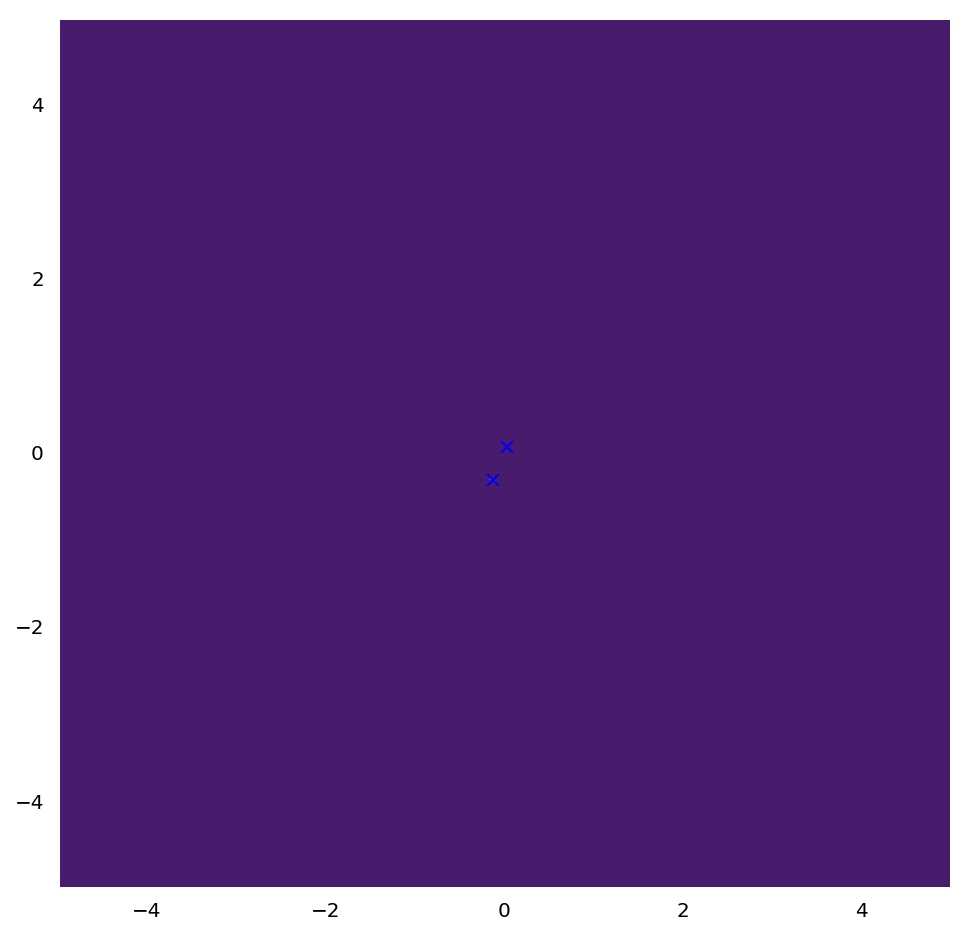

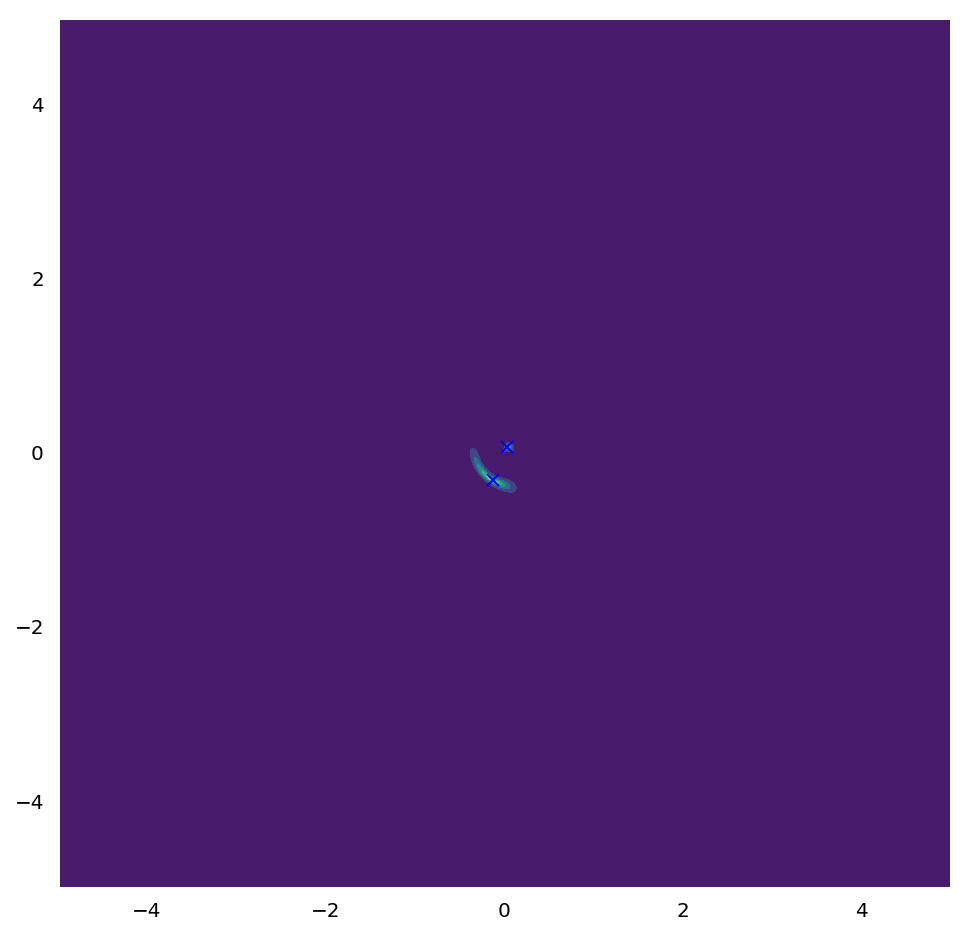

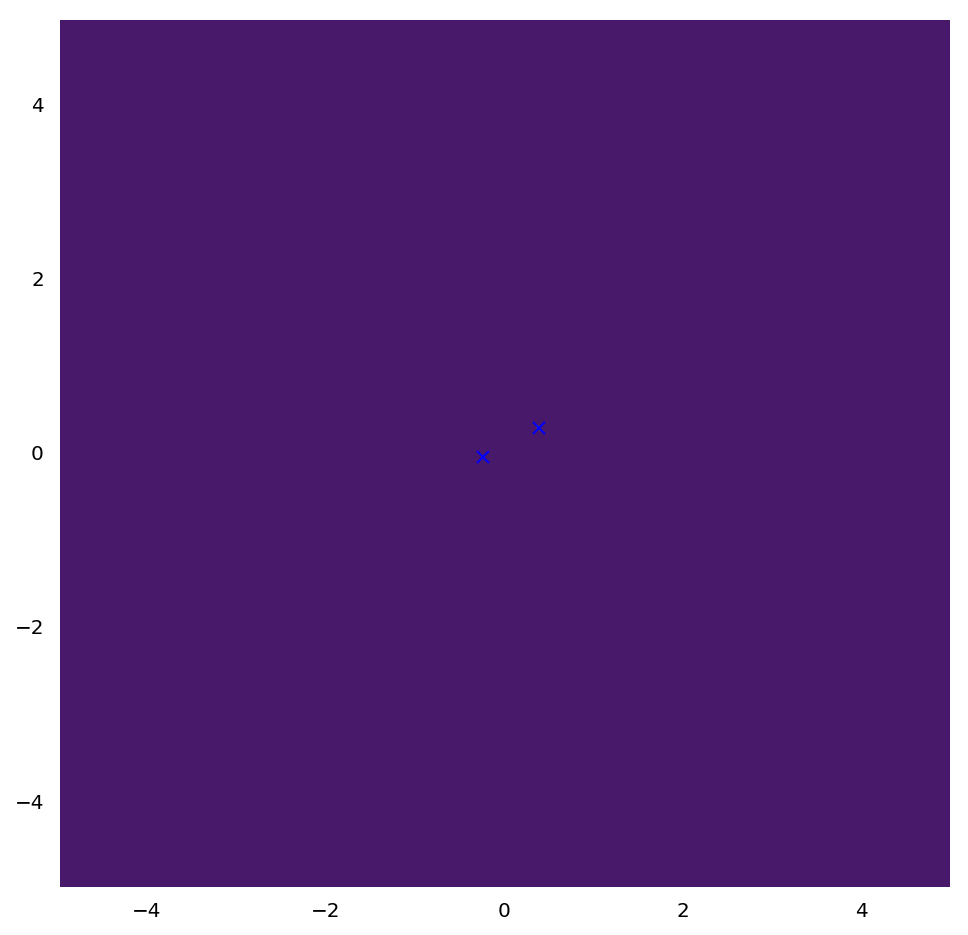

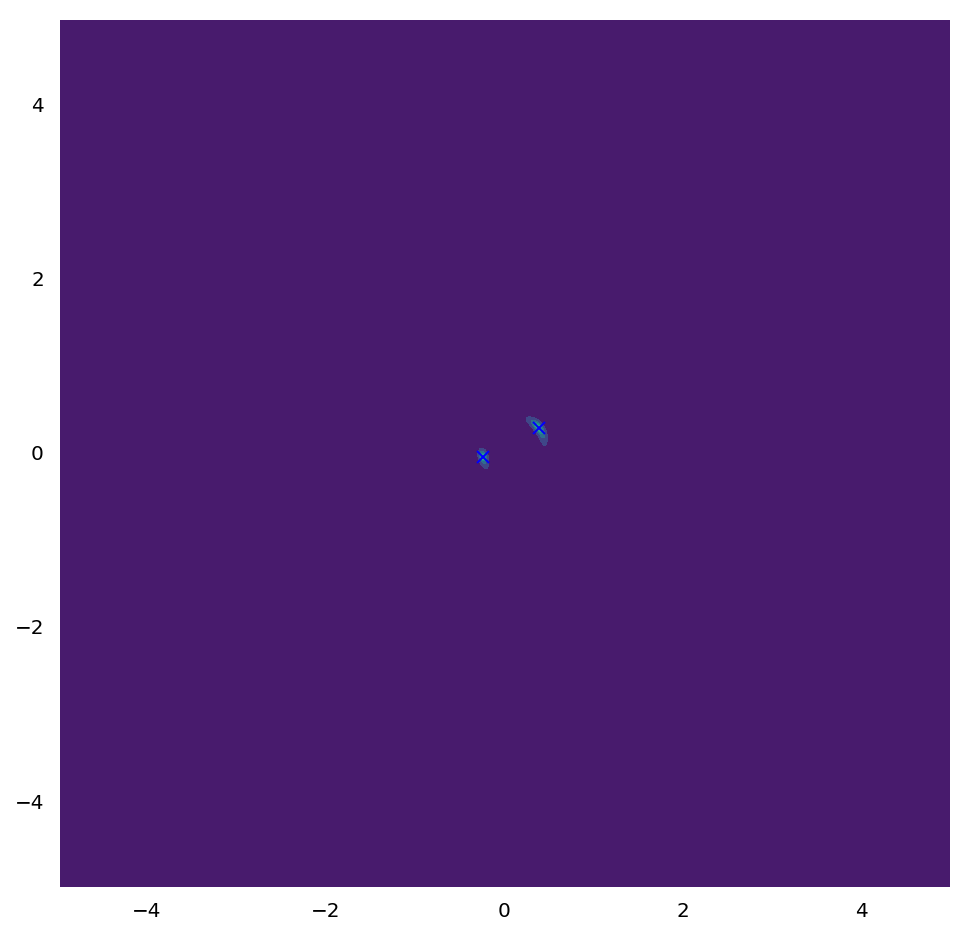

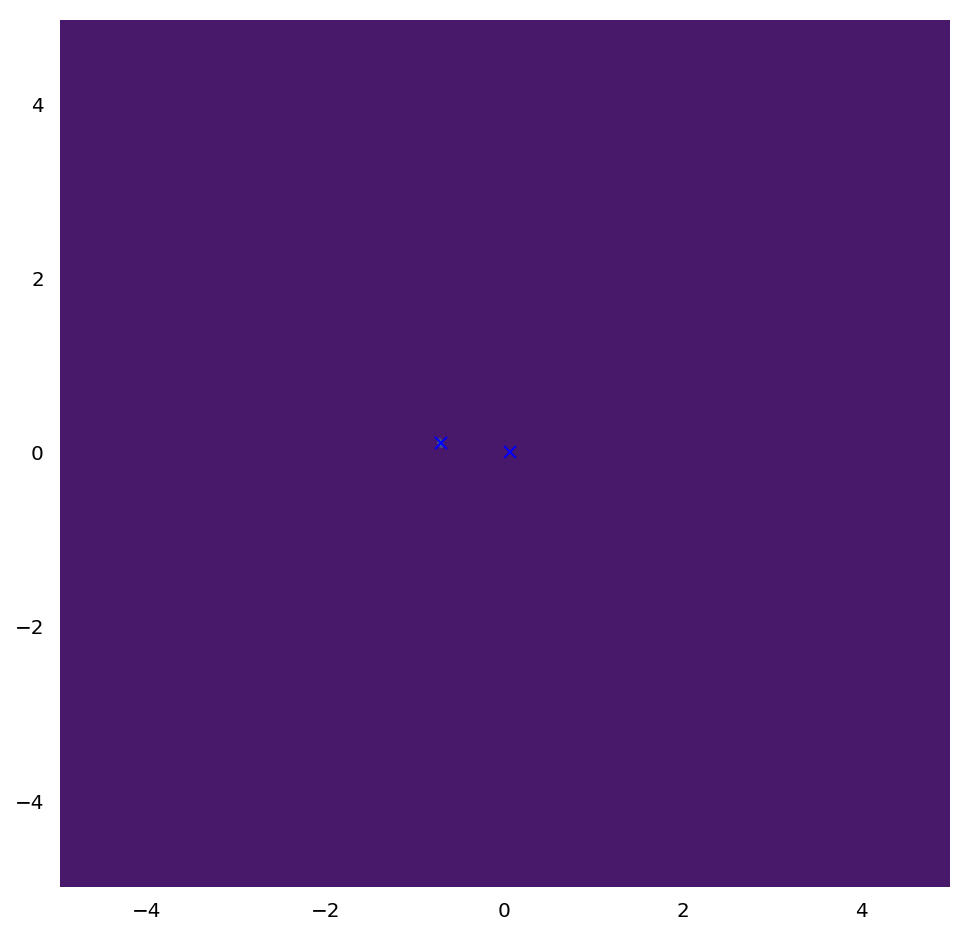

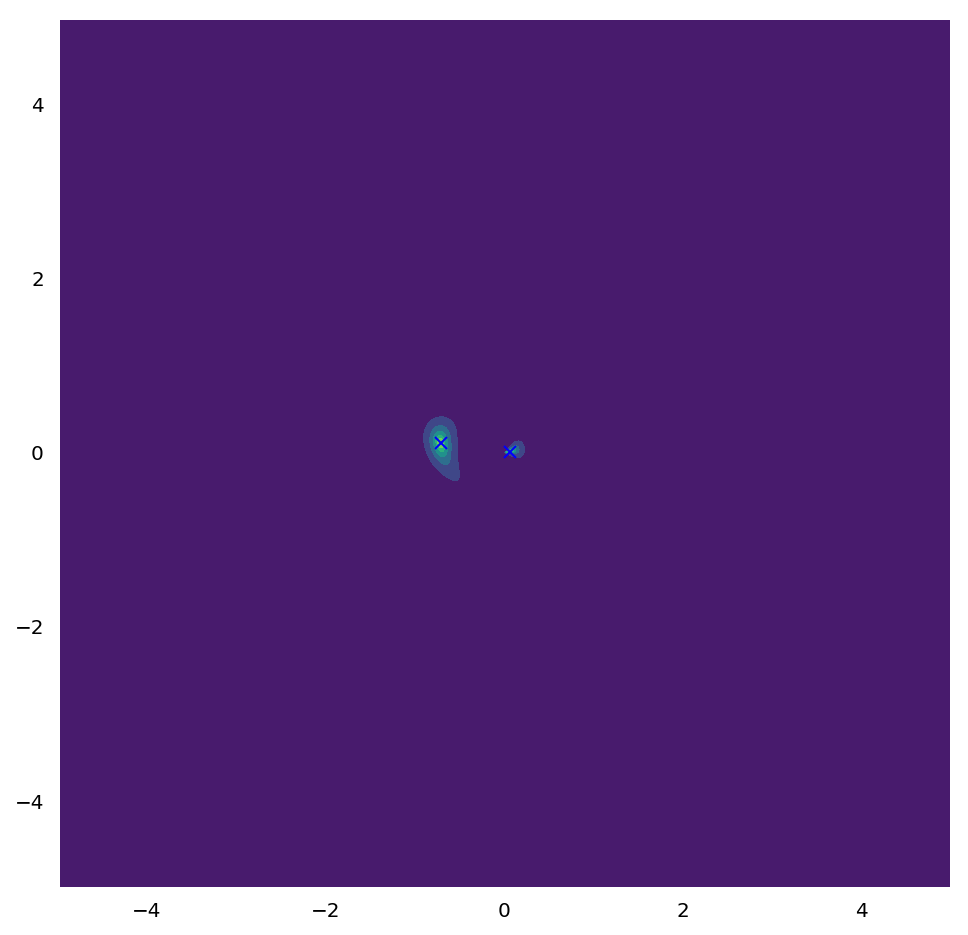

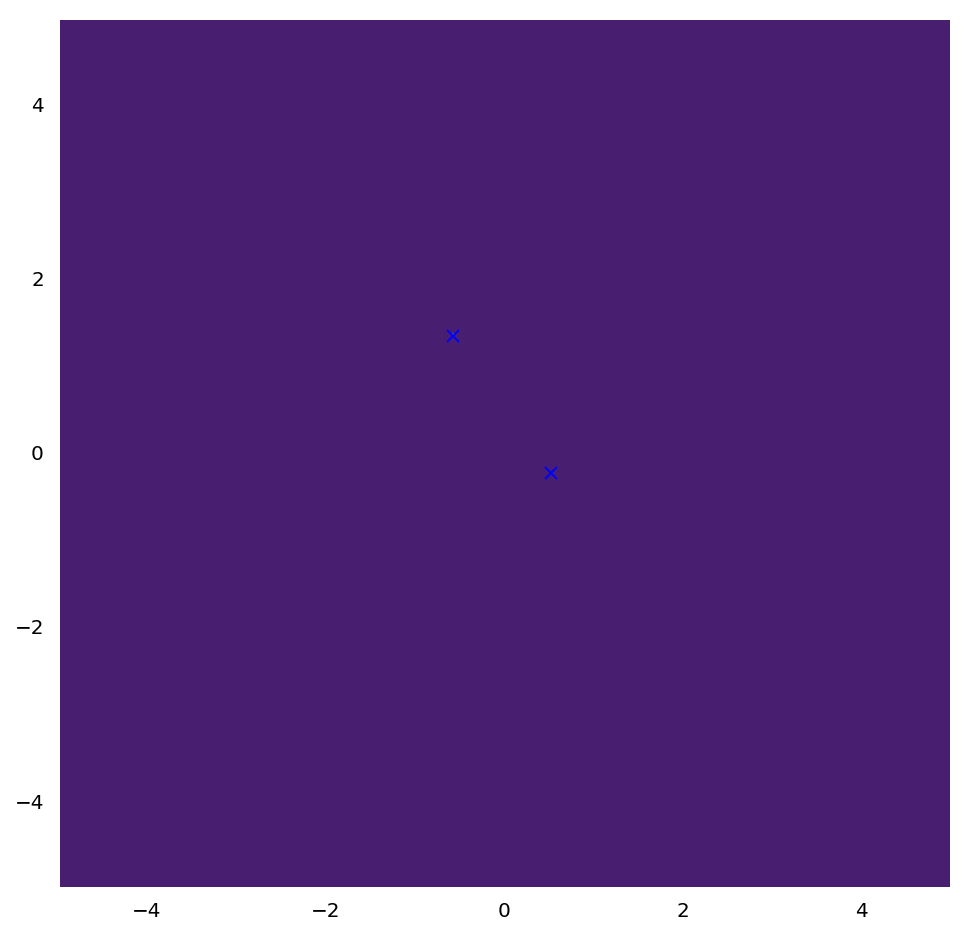

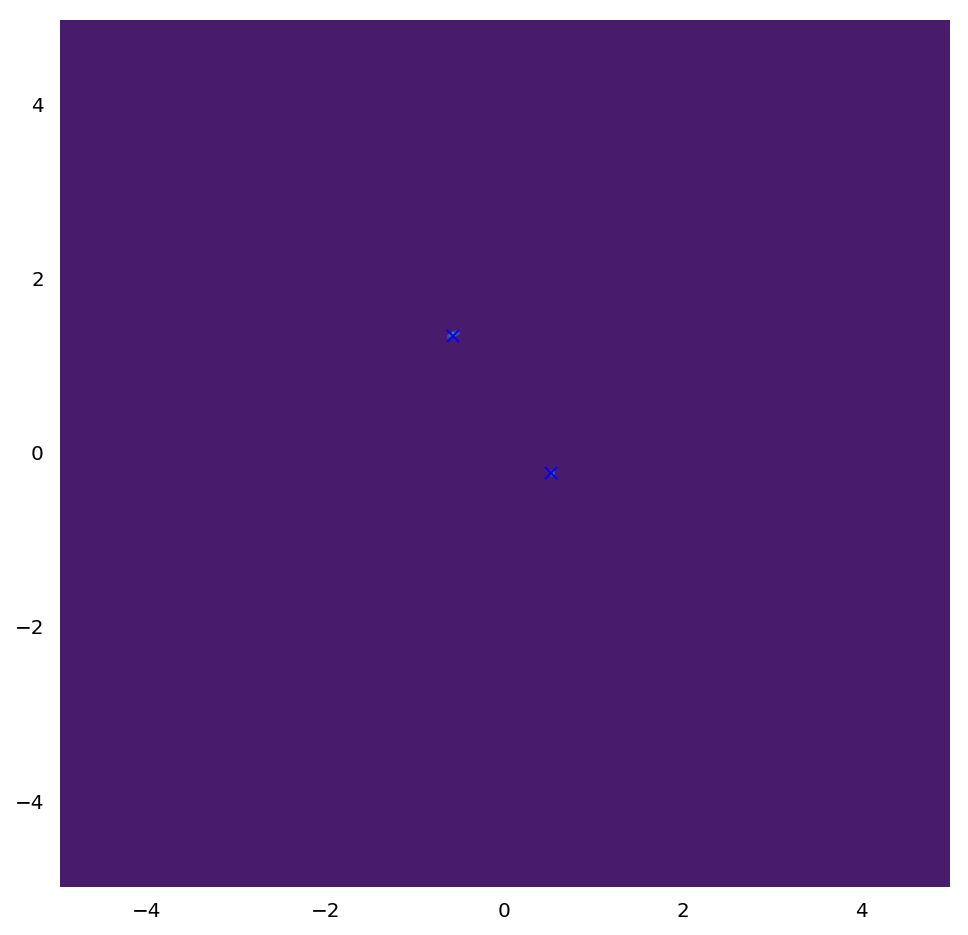

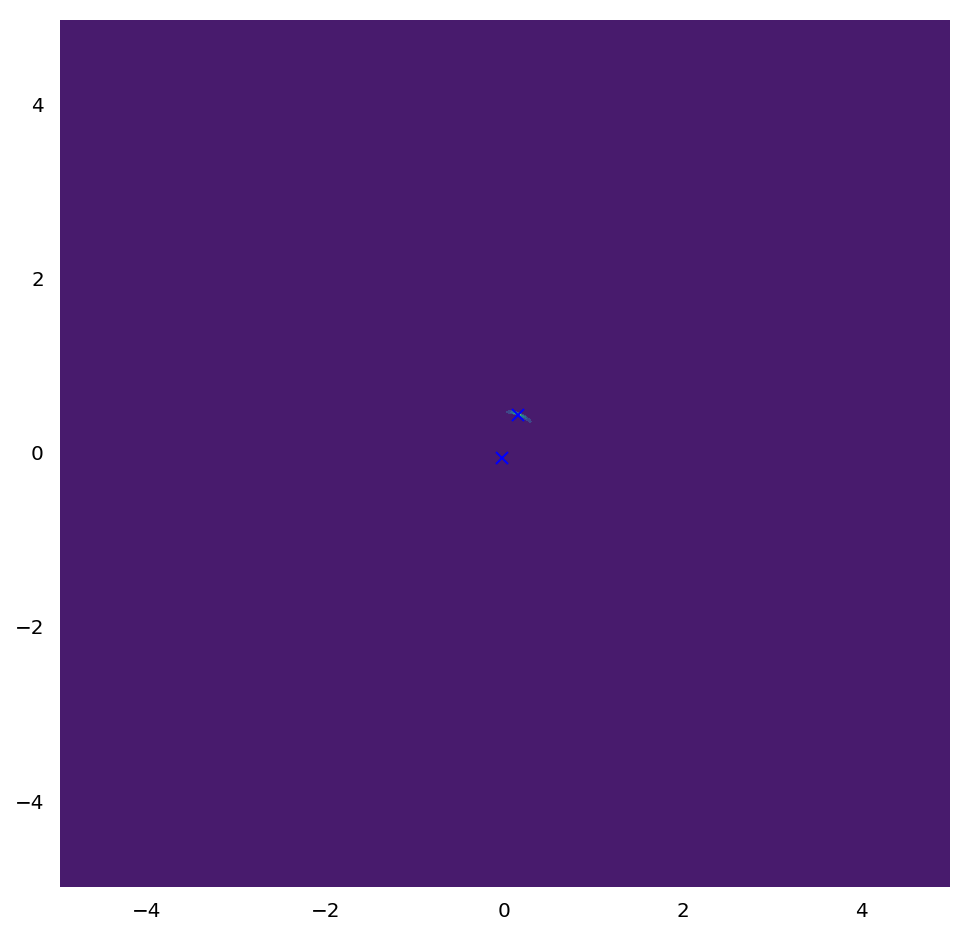

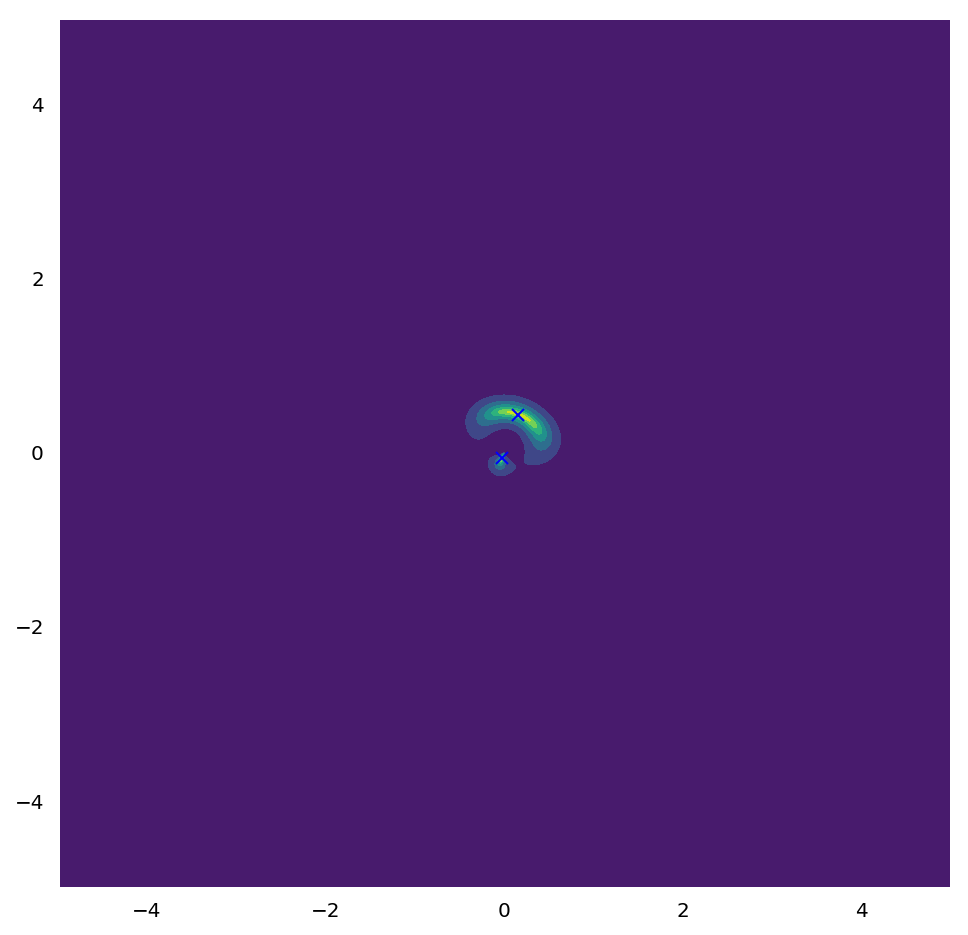

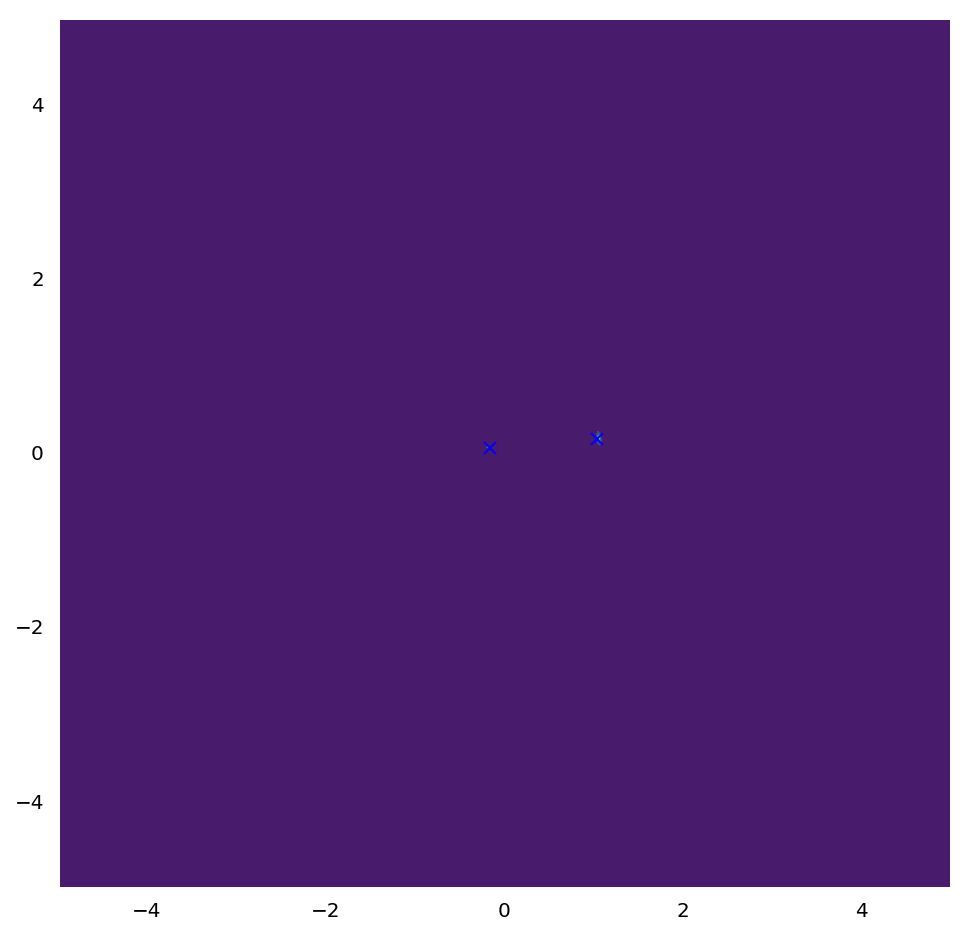

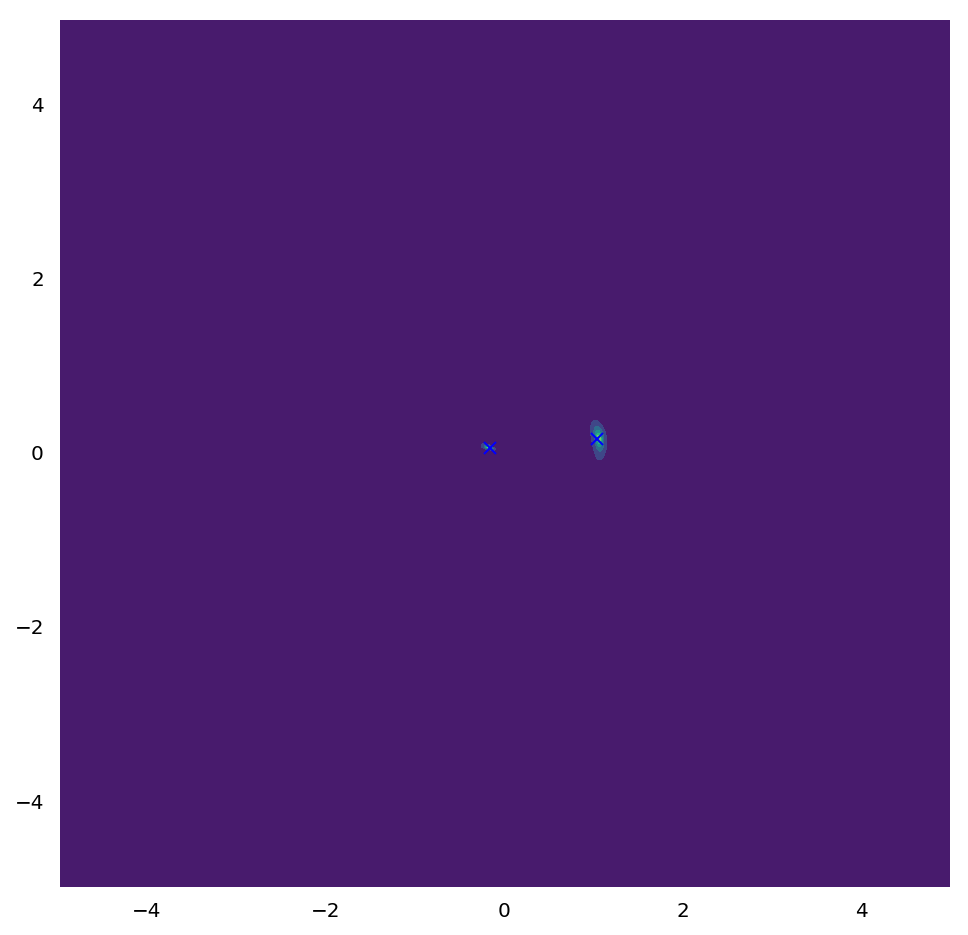

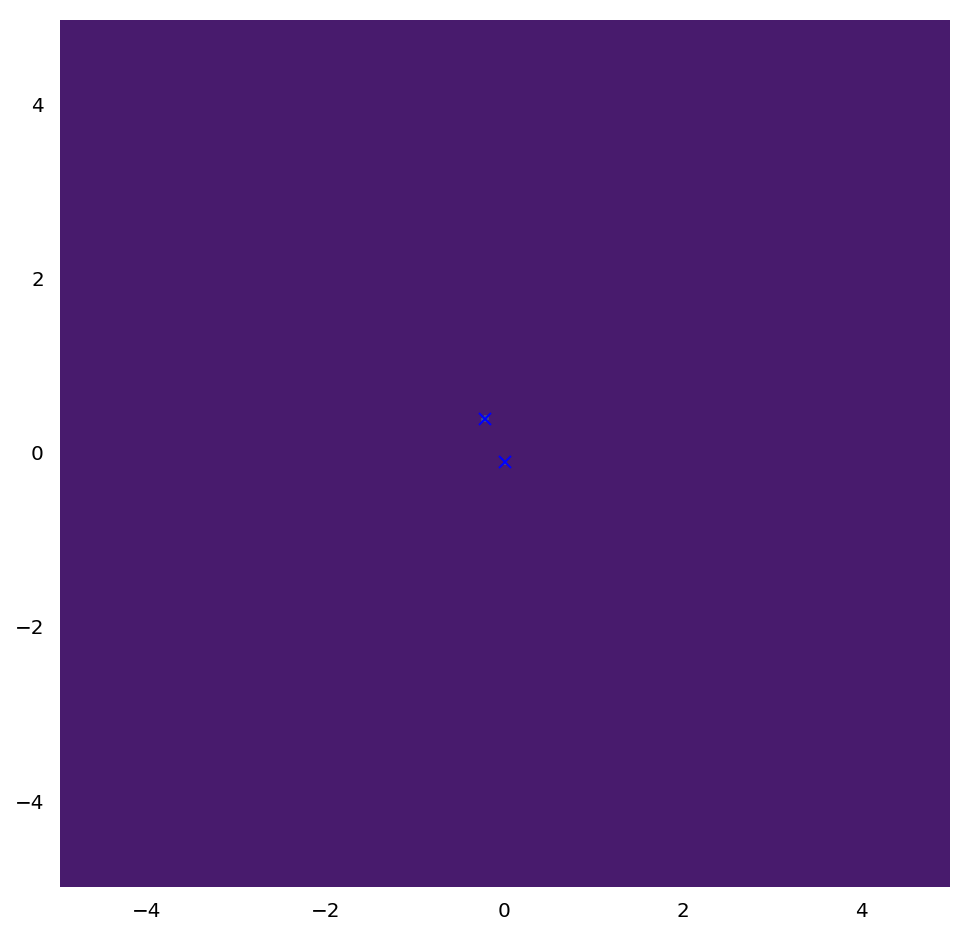

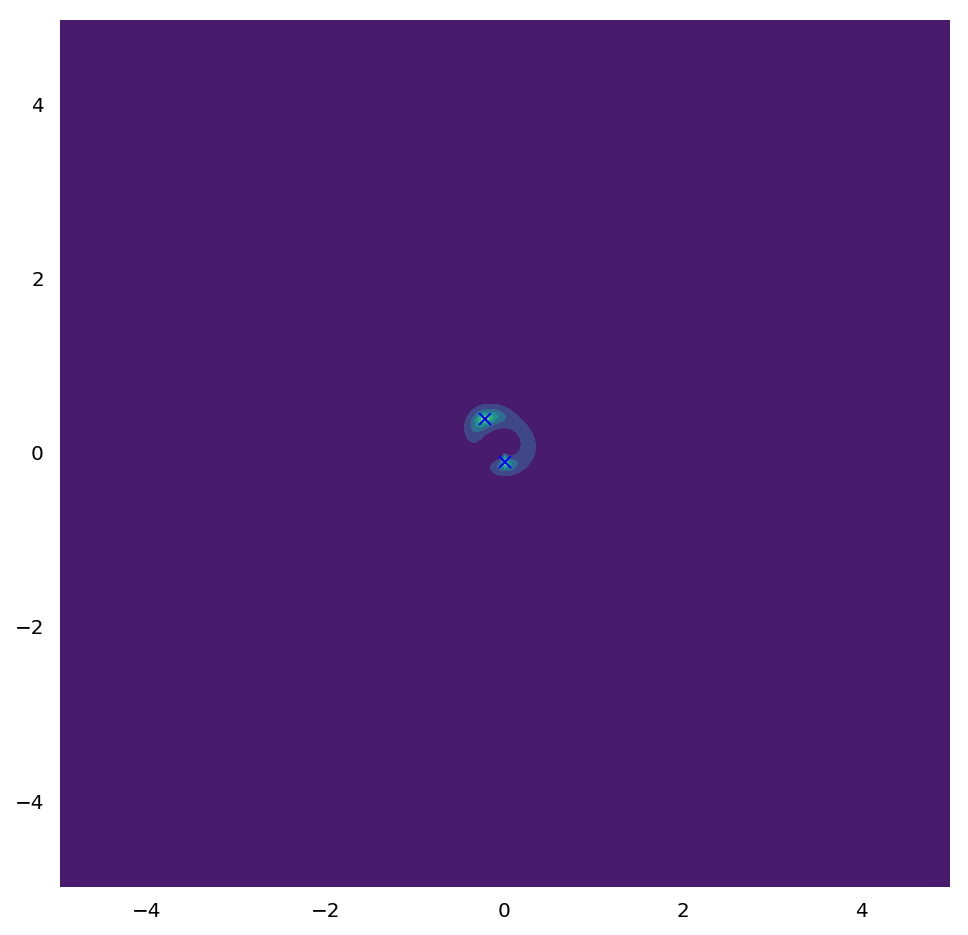

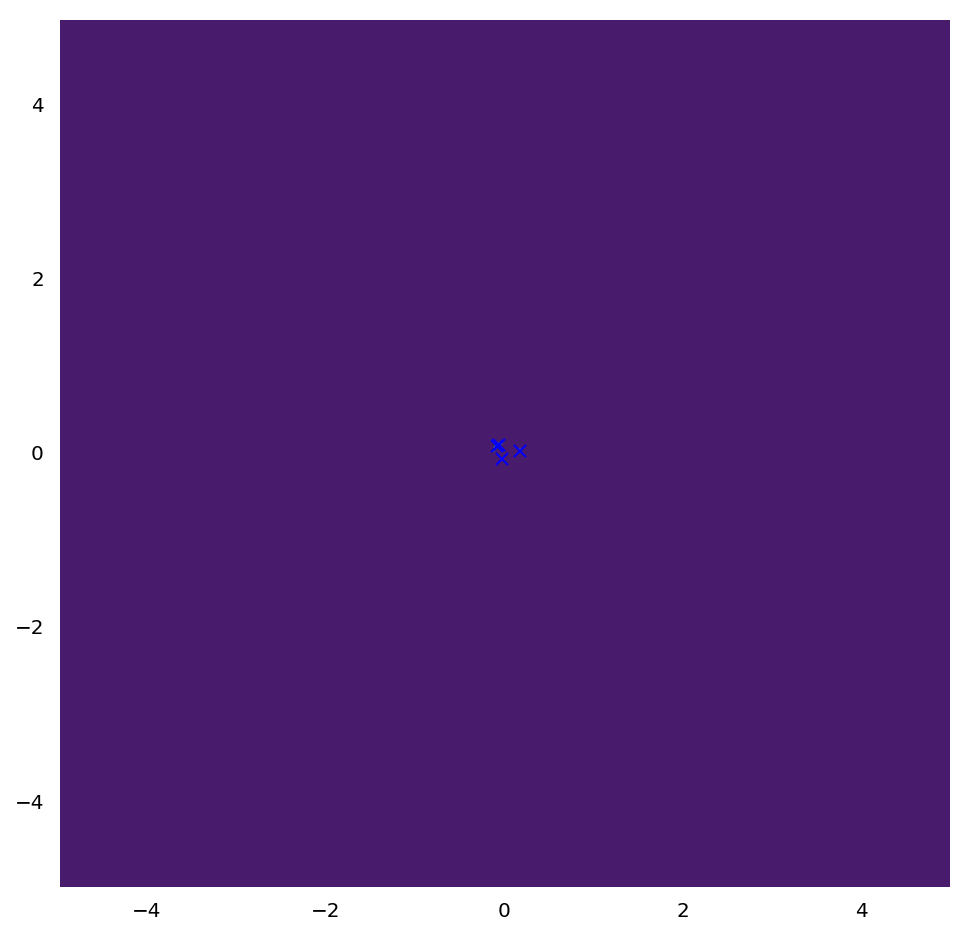

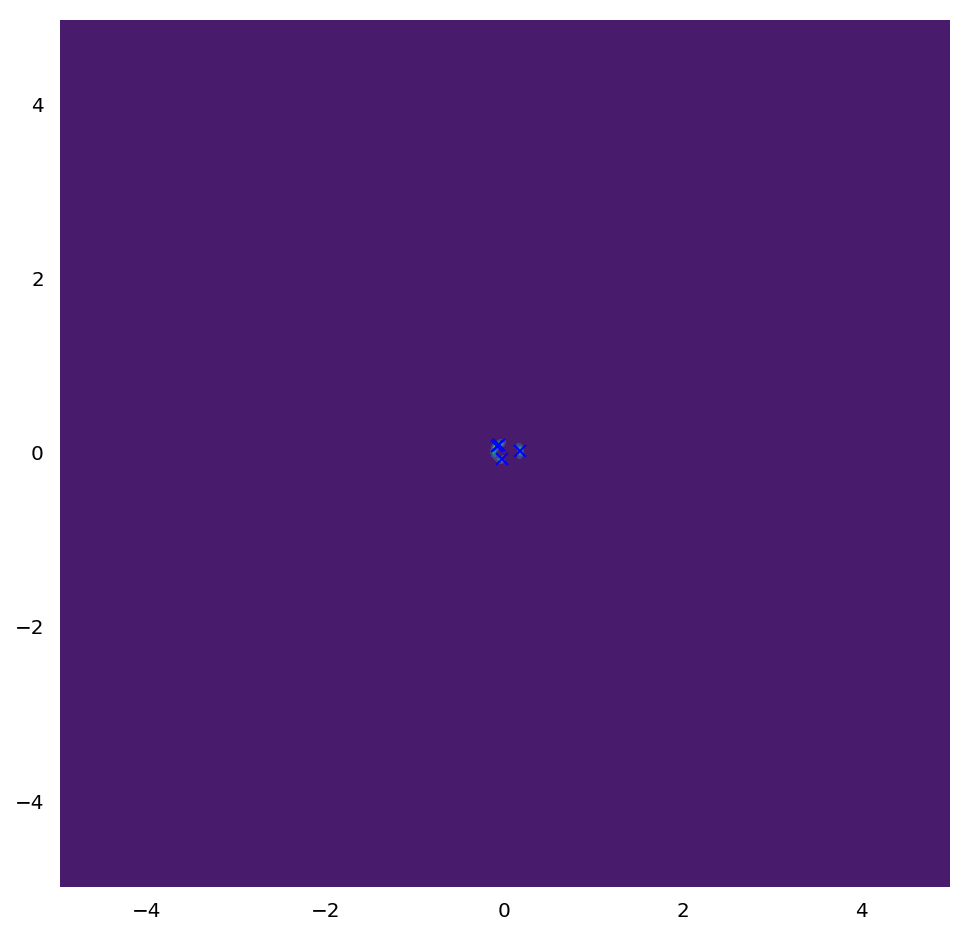

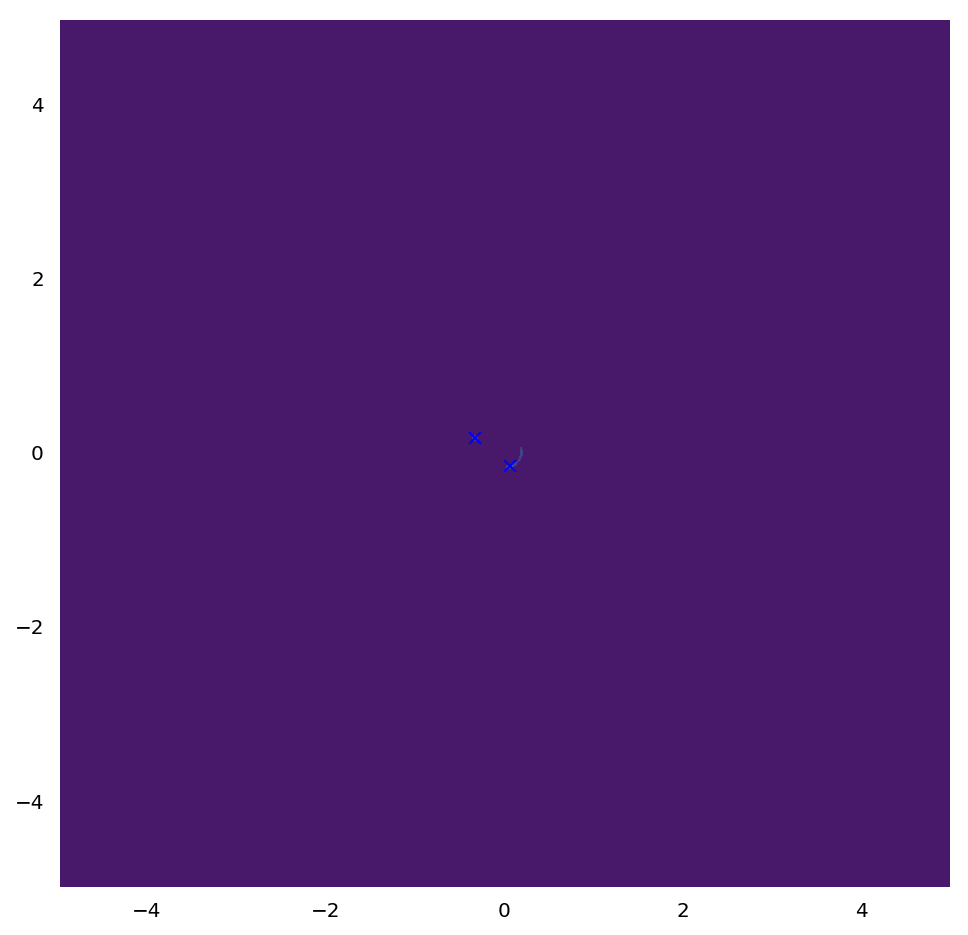

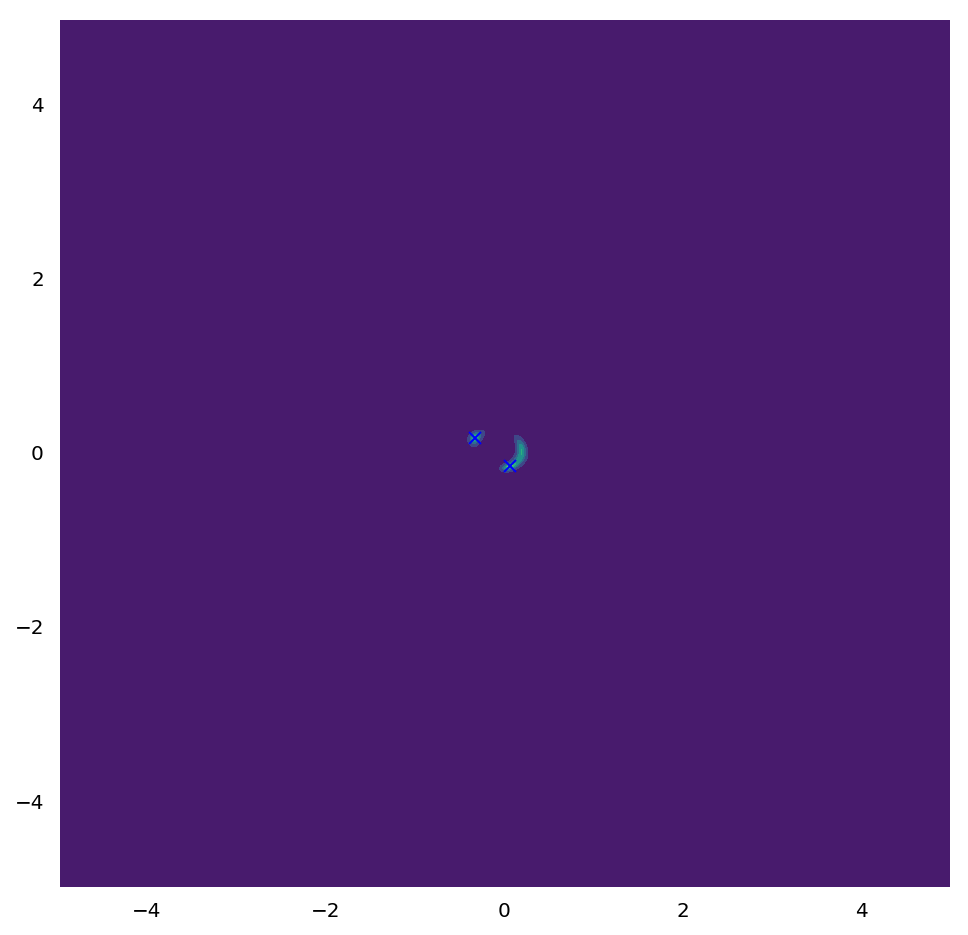

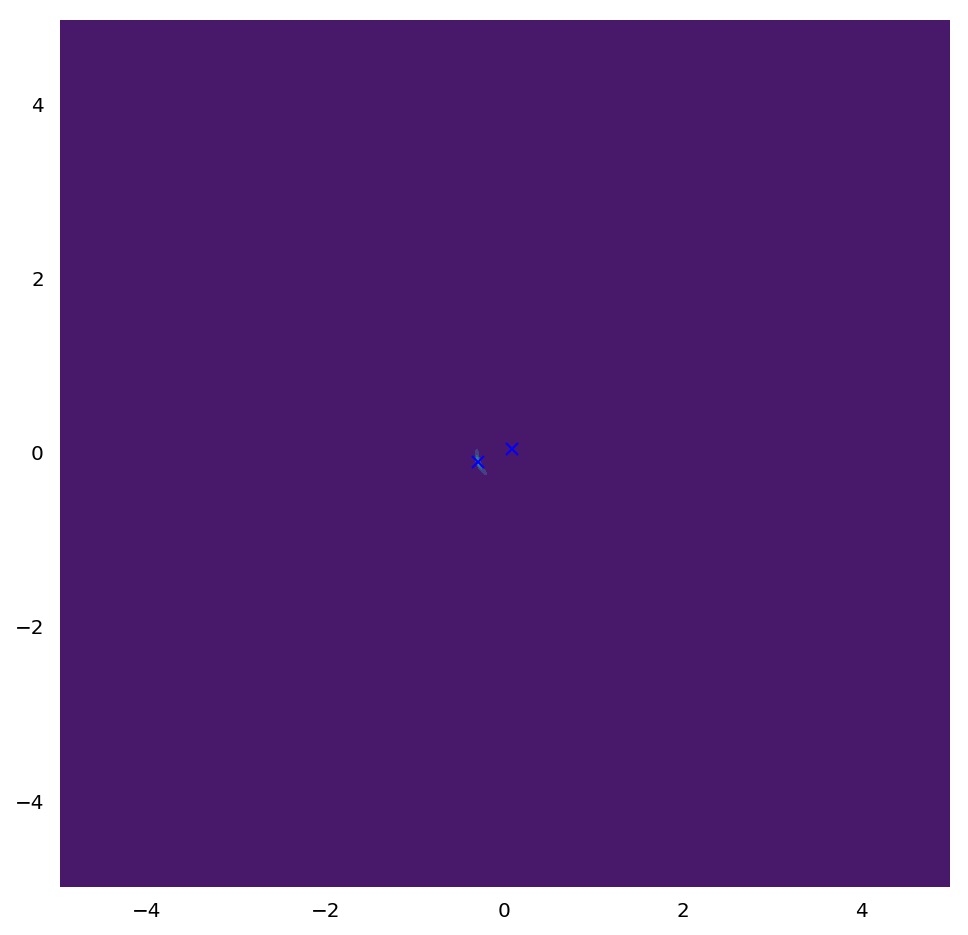

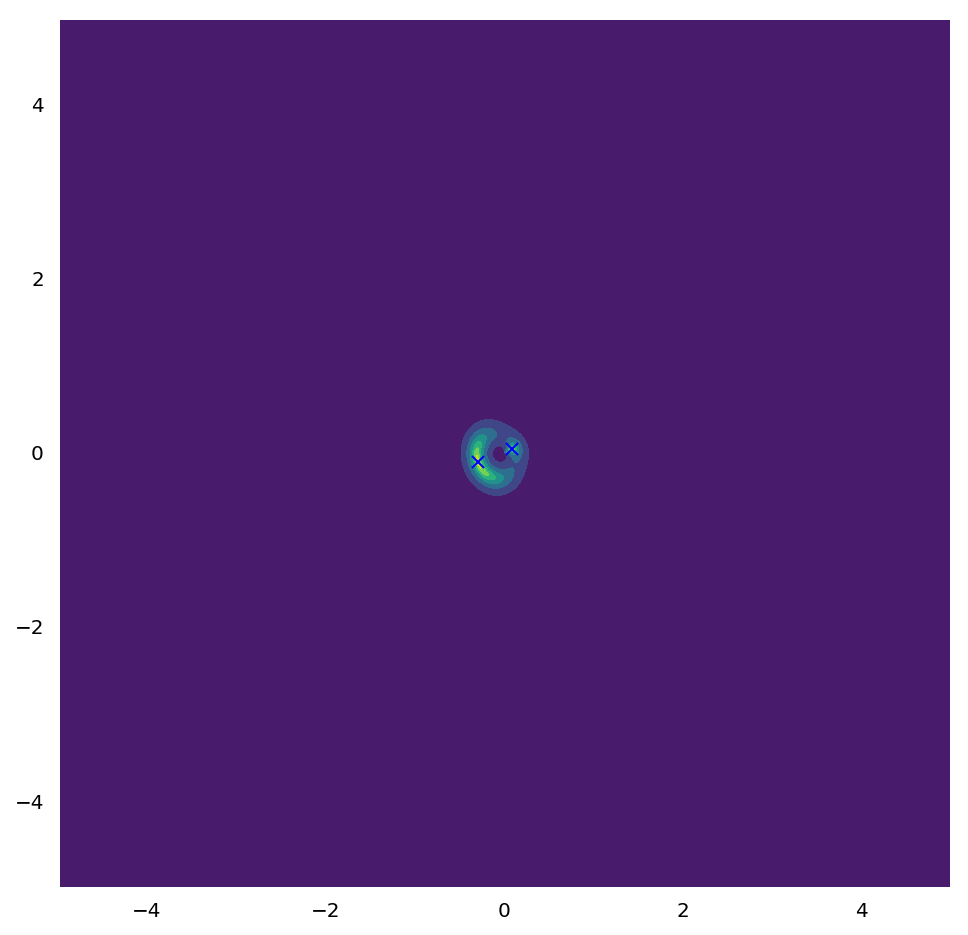

In [3]:
if __name__ == '__main__':

    from tqdm import tqdm_notebook

    dsx = 0.01  # pixel size per side, arcseconds
    nnn = 1000  # number of pixels per side
    xi1, xi2 = ole.make_r_coor(nnn, dsx)
    
    # whether the fits on top of the lensed AGNs
    # where are the positions of hosts in the absence of lenses
    # whether the sersic I use is exactly the same as the one in PhoSim
    # how to model the 2d surface density of an rotated disk 

    hdulist, shb, shd = load_in_data_sne()
            
    for i in tqdm_notebook(shb.index[:10], desc="Main Loop"):
        lensP, srcPb, srcPd = create_cats_sne(i, hdulist, shb, shd)
        generate_lensed_host(xi1, xi2, lensP, srcPb, srcPd)